In [1]:
from collections import deque, namedtuple

import numpy as np
import gymnasium
import PIL.Image

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import time
import random

In [2]:

SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

In [3]:
tf.random.set_seed(SEED)

In [4]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

<a name="3.1"></a>
### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Fire right engine.
* Fire main engine.
* Fire left engine.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

The agent's observation space consists of a state vector with 8 variables:

* Its $(x,y)$ coordinates. The landing pad is always at coordinates $(0,0)$.
* Its linear velocities $(\dot x,\dot y)$.
* Its angle $\theta$.
* Its angular velocity $\dot \theta$.
* Two booleans, $l$ and $r$, that represent whether each leg is in contact with the ground or not.

<a name="3.3"></a>
### 3.3 Rewards

The Lunar Lander environment has the following reward system:

* Landing on the landing pad and coming to rest is about 100-140 points.
* If the lander moves away from the landing pad, it loses reward. 
* If the lander crashes, it receives -100 points.
* If the lander comes to rest, it receives +100 points.
* Each leg with ground contact is +10 points.
* Firing the main engine is -0.3 points each frame.
* Firing the side engine is -0.03 points each frame.

<a name="3.4"></a>
### 3.4 Episode Termination

An episode ends (i.e the environment enters a terminal state) if:

* The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

* The lander's $x$-coordinate is greater than 1.


In [5]:
env = gymnasium.make('LunarLander-v2', render_mode="rgb_array")

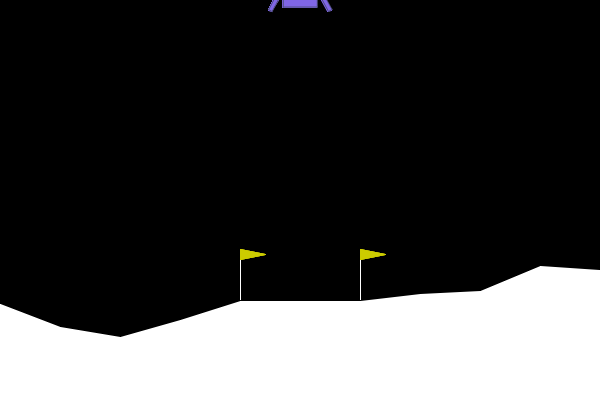

In [6]:
env.reset()
PIL.Image.fromarray(env.render())

In [7]:
num_actions = env.action_space.n
state_size = env.observation_space.shape
print(f"Agent's state size is {state_size} and can take {num_actions} actions!")

Agent's state size is (8,) and can take 4 actions!


In [8]:
# Reset the environment and get the initial state.
initial_state = env.reset()

Once the environment is reset, the agent can start taking actions in the environment by using the `.step()` method. Note that the agent can only take one action per time step. 

In the cell below you can select different actions and see how the returned values change depending on the action taken. Remember that in this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [9]:
action_names = ["Did nothing", "Fired Right Engine", "Fired Main Engine", "Fired Left Engine"]

In [10]:
action = 0
next_state, reward, terminated, truncated, info = env.step(action)
print(f"{action_names[action]}\nNext state: {next_state}\nReward Recieved: {reward}\nEpisode Terminated: {terminated}\nInfo: {info}")

Did nothing
Next state: [ 0.00969496  1.4212197   0.49031258  0.21601267 -0.01110563 -0.10991845
  0.          0.        ]
Reward Recieved: 0.10807961634236563
Episode Terminated: False
Info: {}


In [11]:
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=num_actions)
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation="relu"),
    Dense(units=64, activation="relu"),
    Dense(units=num_actions)
])

optimizer = Adam(learning_rate=ALPHA)

In [12]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$


In [13]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions , rewards, next_states, done_vals = experiences
    y_targets = tf.reduce_max(target_q_network(next_states), axis=1)
    y_targets = rewards + (gamma*y_targets*(1-done_vals))
    
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    return MSE(q_values, y_targets)
    

In [14]:
def agent_learn(experiences, gamma):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)
    gradients = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    for target_weights, qnet_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * qnet_weights + (1.0-TAU) * target_weights)

In [15]:
def get_action(q_values, epsilon):
    if random.random() > epsilon:
        return np.argmax(q_values)
    else:
        return random.choice(np.arange(4))

In [16]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    total_points = 0
    state = env.reset()[0]

    for t in range(max_num_timesteps):
        q_vals = q_network(state.reshape(1,-1))
        action = get_action(q_vals, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        memory_buffer.append(experience(state, action, reward, next_state, terminated))
        if (t+1) % NUM_STEPS_FOR_UPDATE == 0 and len(memory_buffer) > MINIBATCH_SIZE:
            experiences = get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA)
        state = next_state.copy()
        total_points += reward
        if terminated:
            break
    total_point_history.append(total_points)
    avg_latest_pts = np.mean(total_point_history[-num_p_av:])
    epsilon = max(E_MIN, E_DECAY*epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {avg_latest_pts:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {avg_latest_pts:.2f}")

    if avg_latest_pts >= 200:
        print(f"Environment solved in {i+1} episodes!")
        break
total_time = time.time() - start
print(f"\nTotal Runtime: {total_time:.2f} s ({(total_time/60):.2f} min)")

In [37]:
q_network.save('lunar_lander_model.keras')

In [ ]:
filename = "./lunar_lander.mp4"
import imageio
import IPython
import base64

def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()[0]
        frame = env.render()
        video.append_data(frame)
        while not done:    
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, truncated, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

create_video(filename, env, q_network)
embed_mp4(filename)